### A crop hail damage footprint model at your finger tips

This Notebook models crop hail damage footprints from radar using CLIMADA. It allows to set user-specific MESHS thresholds and spatial resolutions as well as the minimum number of fields at each grid cell for it to count as exposure ($n_{thresh}$).

In [19]:
#own
import sys
from utility import aggregate_hazard, exposure_from_gpd,\
                    read_gridded_damages_as_impact, hazard_from_radar,\
                    compute_verification_stats, en_names

from calibration import empirical_calibration_per_exposure
# climada
from climada.util.save import load
from climada.entity import ImpactFunc, ImpactFuncSet
from climada.engine import ImpactCalc, Impact
# others
import numpy as np
import pandas as pd

from climada.util.api_client import Client




First, we specify MESHS threshold, resolution and $n_{thresh}$ that we would like to work with

In [38]:
MESHS_threshold=30 #in mm
resolution=8 #in km
croptype='wheat'
n_thresh=20 #in number of fields


Then, we get the hail hazard data at 1km resolution from the Climada Data-API and coarsen the resolution thereafter. For the aggregation we use the maximum value within a grid cell.

In [21]:
#get hail hazard data at 1km
client=Client()
hazard_1km=client.get_hazard('hail', properties={'variable': 'MESHS'})


<GeoAxes: title={'center': 'Event ID 8: ev_2021-06-21'}>

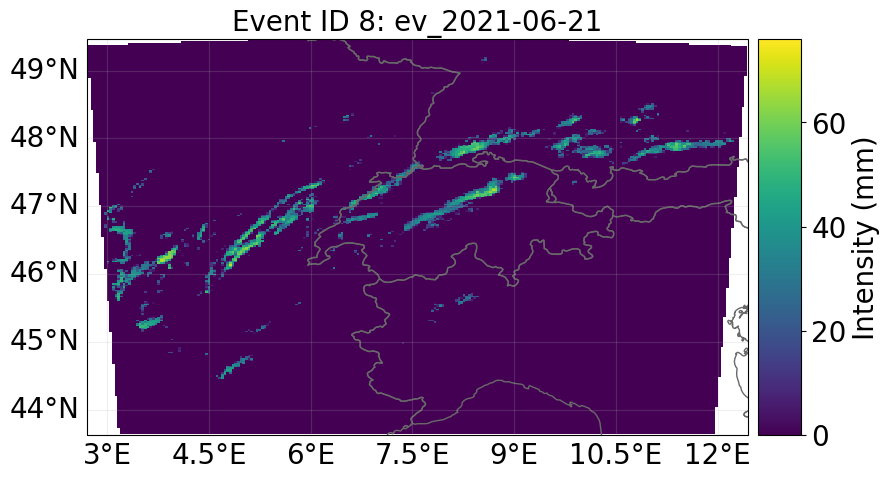

In [22]:
hazard_1km.plot_intensity(event='ev_2021-06-21')

In [24]:
#spatially aggregate to target grid
hazard, _=aggregate_hazard(hazard_1km, original_grid_epsg = 2056, 
                                  extent_new = None, 
                                  cell_size_new = resolution*1000,
                                  projection_new_epsg = 4326,
                                  aggfunc = 'max')

create empty grid with extent None, cell size: 8000
Merge hazard with output grid...
Dissolve hazard intensity in output grid using the following aggregation function: max
Aggregating hazard data from 2017.
Aggregating hazard data from 2019.
Aggregating hazard data from 2021.


So lets now plot the aggregated hazard data for an individual hail date

<GeoAxes: title={'center': 'Event ID 8: ev_2021-06-21'}>

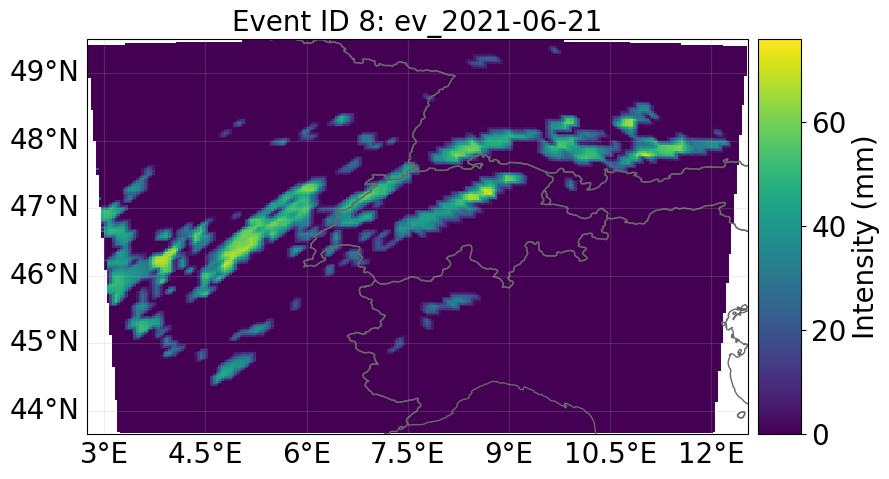

In [25]:
hazard.plot_intensity(event='ev_2021-06-21')

Next, we read the gridded exposure data from the Climada Data-API. For that, we need to additionally specify the croptype. We can also set a minimum number of exposed fields $n_{thresh}$ for a grid point to count as exposure. The exposure value is here a binary field (yes/no) and but can be changed to the number of fields (`n_fields`) or to the total area in ha (`area_ha`), which are available as separate columns in the `exposure.gdf`. For the simple model applied here the binary field used. 

In [26]:
exposure = client.get_exposures('crops', properties={'res_km': f'{resolution}', 'crop': croptype})

exposure.gdf['value'][exposure.gdf['n_fields']<n_thresh]=0

Now, lets plot the exposure as well

<GeoAxes: >

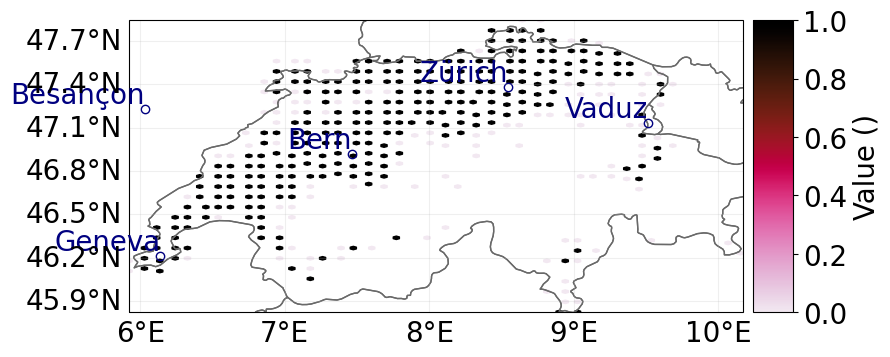

In [27]:
exposure.plot_hexbin(gridsize=100)

We can also investigate some other aspects of our exposure data from information passed on in the gdf

In [28]:
exposure.gdf

,value,n_fields,area_ha,geometry,impf_,latitude,longitude
2301,0,4.0,14.779479,POINT (5.92524 46.11332),1,46.113324,5.925240
2302,0,18.0,73.518349,POINT (5.92324 46.18528),1,46.185275,5.923239
2382,1,104.0,181.236097,POINT (6.02870 46.11467),1,46.114667,6.028698
2383,1,349.0,653.453377,POINT (6.02683 46.18662),1,46.186620,6.026833
2384,1,46.0,109.352647,POINT (6.02496 46.25857),1,46.258573,6.024964
...,...,...,...,...,...,...,...
5155,0,7.0,6.331312,POINT (9.60100 47.47056),1,47.470560,9.601004
5229,0,17.0,12.290353,POINT (9.68580 46.96504),1,46.965038,9.685800
5235,0,15.0,4.816351,POINT (9.70401 47.39661),1,47.396606,9.704012
5544,0,11.0,1.823068,POINT (10.07425 46.30872),1,46.308716,10.074249


(array([0.12585034, 0.05782313, 0.07142857, 0.0170068 , 0.03061224,
        0.03061224, 0.01360544, 0.01360544, 0.02380952, 0.00680272,
        0.00340136, 0.0170068 , 0.0170068 , 0.01020408, 0.01360544,
        0.00680272, 0.00680272, 0.01360544, 0.00680272, 0.00680272,
        0.00680272]),
 array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5]),
 <BarContainer object of 21 artists>)

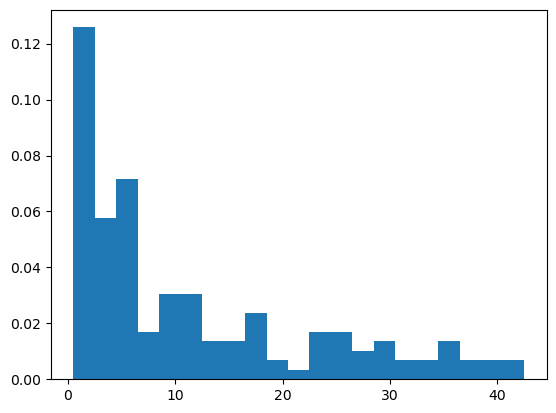

In [29]:
import matplotlib.pyplot as plt
plt.hist(exposure.gdf['n_fields'],bins=np.arange(0.5,44,2),density=True)

Next we define the impact function, which is a step function defined by threshold s

In [39]:
# We initialise an ImpactFunc for hail damage to crops.
def step_function(x,threshold):
    y=np.where(x<threshold,0,1)
    return y

haz_type = "HL"
id = 1
name = "HL agriculture damage"
# provide unit of the hazard intensity
intensity_unit = "mm"
# provide values for the hazard intensity range
intensity = np.arange(20, 101, 1)
paa=step_function(intensity,MESHS_threshold)
mdd = np.ones(len(intensity))
imp_fun = ImpactFunc(
    id=id,
    name=name,
    intensity_unit=intensity_unit,
    haz_type=haz_type,
    intensity=intensity,
    mdd=mdd,
    paa=paa,
)

# check if the all the attributes are set correctly
imp_fun.check()
impf_set = ImpactFuncSet([imp_fun])
impf_set.check()

<Axes: title={'center': 'HL 1: HL agriculture damage'}, xlabel='Intensity (mm)', ylabel='Impact (%)'>

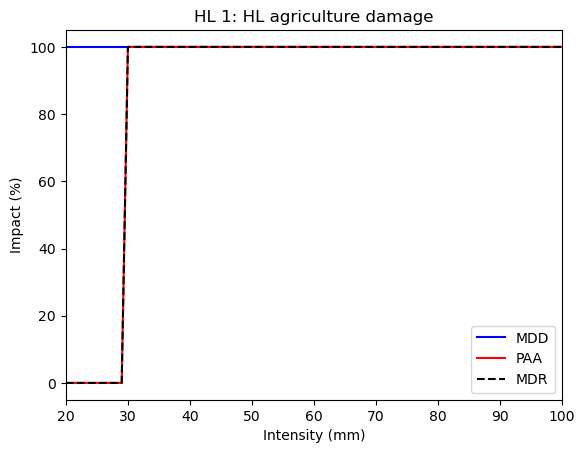

In [40]:
imp_fun.plot()

Now, we are ready to compute the impact (i.e. the damage yes or no field). 

In [41]:
impact = ImpactCalc(exposure, impf_set, hazard).impact(save_mat=True)


Now, lets plot the impact for a single event. Aggregated in a hexbin plot the impact is the number of grid points with damage expected.

<GeoAxes: >

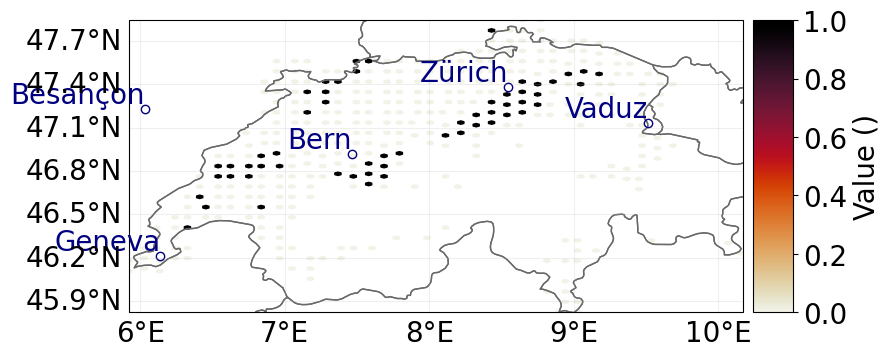

In [42]:
impact_now=impact.select(event_names=['ev_2021-06-21'])
impact_now.plot_hexbin_impact_exposure(event_id=impact_now.event_id[0], gridsize=100)


Now, we can read the damage data and compare it visually to the modelled impact. We also  Setting ```binary_damages=True``` returns the damage footprint

<GeoAxes: >

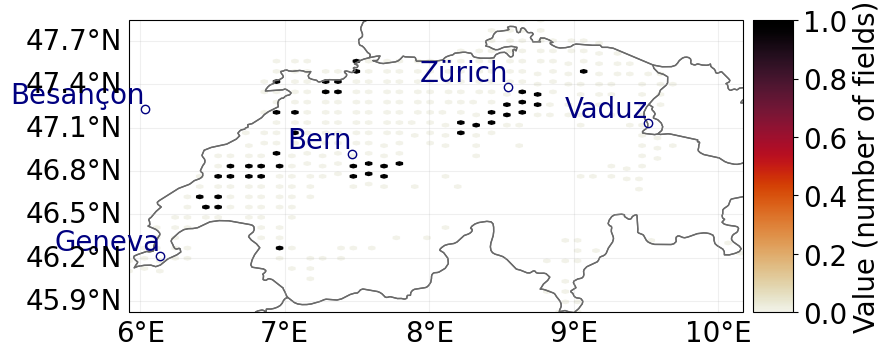

In [43]:
ds = client.get_dataset_info(data_type='hail_damage_crops', properties={
    'res_km': f'{resolution}',
    'crop': croptype,
})
_, [impact_file] = client.download_dataset(ds)
 
damages = Impact.from_hdf5(impact_file)
from copy import deepcopy
damages_binary=deepcopy(damages)

#replace number of fields with 1 where number of fields is larger than 1
indices=damages_binary.imp_mat.nonzero()
imp_mat_binary=damages_binary.imp_mat.copy()
imp_mat_binary[indices]=1
damages_binary.imp_mat=imp_mat_binary

#select and plot damages
damages_now=damages_binary.select(event_names=['ev_2021-06-21'])
damages_now.plot_hexbin_impact_exposure(event_id=damages_now.event_id[0], gridsize=100)

Now, how do verification scores look like for this data? For this we can use the `empirical_calibration_per_exposure` function which matches hazard, exposure and damages at the hazard centroids. This can be done for either one single event (use `damages_now`) or all event (use `damages`). The results will be valid at the hazard grid (e.g. 8km). Exposure and damages can be passed also at higher resolution grids.

In [47]:
_, _, _, _, values_at_centroid_all,_ =\
                    empirical_calibration_per_exposure(hazard_object = hazard,
                                                       exposure_object = exposure,
                                                       damages = damages,
                                                       exposure_type = 'agriculture',
                                                       variable = 'MESHS')

2023-11-02 10:50:24,005 - climada.util.coordinates - WARNING - This function has been renamed, use match_coordinates instead.


Then from `values_at_centroid_all`, we can compute verification statistics, based on the indicated n_thresh

In [48]:
df, npred = compute_verification_stats(values_at_centroid_all,
                                               variable = 'MESHS',
                                               exposure_thresh=n_thresh)
print(df)
     

            FAR     1-FAR       POD       NER       CSI       HSS  SEDI  \
MESHS                                                                     
20.0   0.619824  0.380176  0.860795  0.800404  0.358156  0.428737   NaN   
21.0   0.612694  0.387306  0.849432  0.808889  0.362424  0.435471   NaN   
22.0   0.610372  0.389628  0.832386  0.814545  0.361282  0.434949   NaN   
23.0   0.603851  0.396149  0.818182  0.822626  0.364096  0.439840   NaN   
24.0   0.593438  0.406562  0.809659  0.831919  0.371094  0.450157   NaN   
...         ...       ...       ...       ...       ...       ...   ...   
82.0   0.285714  0.714286  0.014205  0.999193  0.014124  0.023115   NaN   
83.0   0.200000  0.800000  0.011364  0.999596  0.011331  0.018989   NaN   
85.0   0.333333  0.666667  0.005682  0.999596  0.005666  0.009183   NaN   
86.0   0.500000  0.500000  0.002841  0.999596  0.002833  0.004249   NaN   
92.0   1.000000  0.000000  0.000000  0.999596  0.000000 -0.000706   NaN   

             PC      POF

Finally, we can print the calibration results

In [49]:
th=MESHS_threshold
while th not in df.index:
    th+=1

print(f'crop: {croptype}')
print(f'resolution: {resolution}km')
print(f'MESHS threshold: {MESHS_threshold}')
print(f'n_thresh: {n_thresh}')
print(f'POD: {df.POD[th]}, FAR: {df.FAR[th]}, HSS: {df.HSS[th]}, BIAS: {df.B[th]}')

crop: wheat
resolution: 8km
MESHS threshold: 30
n_thresh: 20
POD: 0.7443181818181818, FAR: 0.5536626916524702, HSS: 0.4765527226325734, BIAS: 1.6676136363636365
